In [1]:
# limits the GPU so that it does not crash
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

**Data preprocessing**

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  Activation, Dropout, BatchNormalization

In [3]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

def create_df(train_dir, valid_dir, test_dir):
    # train dataframe
    files, classes = define_paths(train_dir)
    train_df = define_df(files, classes)
    # validation dataframe
    files, classes = define_paths(valid_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(test_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df


In [4]:
def scalar(img):
    return img

def create_gens(train_df, valid_df, test_df):
    img_size = (224, 224)
    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)
    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True)
    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True)
    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False)
    return train_gen, valid_gen, test_gen


In [5]:
train_dir = './dataset/train'
test_dir = './dataset/test'
valid_dir = './dataset/valid'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df)

Found 613 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.


In [6]:
train_df

,filepaths,labels
0,./dataset/train\adenocarcinoma_left.lower.lobe...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
1,./dataset/train\adenocarcinoma_left.lower.lobe...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
2,./dataset/train\adenocarcinoma_left.lower.lobe...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
3,./dataset/train\adenocarcinoma_left.lower.lobe...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
4,./dataset/train\adenocarcinoma_left.lower.lobe...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
...,...,...
608,./dataset/train\squamous.cell.carcinoma_left.h...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
609,./dataset/train\squamous.cell.carcinoma_left.h...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
610,./dataset/train\squamous.cell.carcinoma_left.h...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
611,./dataset/train\squamous.cell.carcinoma_left.h...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


**Training and testing model created using EfficientNetB3**

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

filepath = './model/best_model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(
    x=train_gen,
    epochs=50,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.1677 - accuracy: 0.5840
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ./model\best_model.h5
20/20 [==============================] - 19s 378ms/step - loss: 1.1677 - accuracy: 0.5840 - val_loss: 3.6824 - val_accuracy: 0.5000
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.7945
Epoch 2: val_accuracy improved from 0.50000 to 0.52778, saving model to ./model\best_model.h5
20/20 [==============================] - 4s 181ms/step - loss: 0.6040 - accuracy: 0.7945 - val_loss: 2.1475 - val_accuracy: 0.5278
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.3819 - accuracy: 0.8320
Epoch 3: val_accuracy did not improve from 0.52778
20/20 [==============================] - 3s 156ms/step - loss: 0.3819 - accuracy: 0.8320 - val_loss: 2.2776 - val_accuracy: 0.5000
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('./model/best_model.h5')

train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print('-' * 20)

10/10 [==============================] - 3s 262ms/step - loss: 0.6046 - accuracy: 0.8476
Train Loss:  0.007735582999885082
Train Accuracy:  0.9983686804771423
--------------------
Validation Loss:  0.4423949420452118
Validation Accuracy:  0.9027777910232544
--------------------
Test Loss:  0.604565441608429
Test Accuracy:  0.8476190567016602
--------------------


**Training and testing model created using ResNet50**

In [9]:
from tensorflow.keras.applications import ResNet50

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

filepath = './model/best_model_resnet.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(
    x=train_gen,
    epochs=50,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.0034 - accuracy: 0.6525
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to ./model\best_model_resnet.h5
20/20 [==============================] - 9s 271ms/step - loss: 1.0034 - accuracy: 0.6525 - val_loss: 1.8808 - val_accuracy: 0.6250
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.9119
Epoch 2: val_accuracy improved from 0.62500 to 0.83333, saving model to ./model\best_model_resnet.h5
20/20 [==============================] - 3s 166ms/step - loss: 0.2589 - accuracy: 0.9119 - val_loss: 0.8085 - val_accuracy: 0.8333
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9576
Epoch 3: val_accuracy did not improve from 0.83333
20/20 [==============================] - 3s 145ms/step - loss: 0.1186 - accuracy: 0.9576 - val_loss: 1.1422 - val_accuracy: 0.7361
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.0623 

In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

model = load_model('./model/best_model_resnet.h5')

train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print('-' * 20)

10/10 [==============================] - 2s 232ms/step - loss: 1.0515 - accuracy: 0.7905
Train Loss:  0.0023765484802424908
Train Accuracy:  0.9983686804771423
--------------------
Validation Loss:  0.6109516620635986
Validation Accuracy:  0.9027777910232544
--------------------
Test Loss:  1.0514733791351318
Test Accuracy:  0.7904762029647827
--------------------


**Training and testing model created using InceptionV3**

In [11]:
from tensorflow.keras.applications import InceptionV3

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

filepath = './model/best_model_inceptionv3.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(
    x=train_gen,
    epochs=50,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.8895 - accuracy: 0.5041
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to ./model\best_model_inceptionv3.h5
20/20 [==============================] - 12s 329ms/step - loss: 1.8895 - accuracy: 0.5041 - val_loss: 11.8944 - val_accuracy: 0.4167
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.3275 - accuracy: 0.6525
Epoch 2: val_accuracy improved from 0.41667 to 0.47222, saving model to ./model\best_model_inceptionv3.h5
20/20 [==============================] - 3s 162ms/step - loss: 1.3275 - accuracy: 0.6525 - val_loss: 9.7517 - val_accuracy: 0.4722
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.0497 - accuracy: 0.6917
Epoch 3: val_accuracy did not improve from 0.47222
20/20 [==============================] - 3s 139ms/step - loss: 1.0497 - accuracy: 0.6917 - val_loss: 8.1255 - val_accuracy: 0.4306
Epoch 4/50
20/20 [==============================] - ETA: 0s - l

In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

model = load_model('./model/best_model_inceptionv3.h5')

train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print('-' * 20)

10/10 [==============================] - 3s 277ms/step - loss: 2.1912 - accuracy: 0.4413
Train Loss:  0.16538774967193604
Train Accuracy:  0.9396411180496216
--------------------
Validation Loss:  0.8136470913887024
Validation Accuracy:  0.75
--------------------
Test Loss:  2.191193103790283
Test Accuracy:  0.4412698447704315
--------------------


**Creating and testing the Ensemble model**

In [13]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

input_shape = img_shape

model_inceptionv3 = load_model('./model/best_model_inceptionv3.h5')
model = load_model('./model/best_model.h5')
model_resnet = load_model('./model/best_model_resnet.h5')

input_layer = Input(shape=(input_shape))

output_inceptionv3 = model_inceptionv3(input_layer)
output_model = model(input_layer)
output_resnet = model_resnet(input_layer)

average = Average()([output_inceptionv3, output_model, output_resnet])

ensemble_model = Model(inputs=input_layer, outputs=average)

ensemble_model.save('./model/final_ensemble_model.h5')

In [14]:
model = load_model('./model/final_ensemble_model.h5')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

C:\Users\prais\AppData\Local\Temp\ipykernel_4968\1939376018.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0 0 3 0 0
 0 0 0 1 0 1 0 3 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 3 0 0 0 0 1 3 1 0 0
 0 0 0 0 0 3 0 0 1 1 1 1 3 3 0 0 1 0 1 0 0 3 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 0 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 0
 3 3 3 3 3 3 3 3 0 3 3 3 3 3 0 3 3 3 0 3 0 3 3 3 0 3 3 3 0 3 3 3 3 3 3 0 3
 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 0 3]


In [15]:
import tensorflow as tf

model = tf.keras.models.load_model('./model/final_ensemble_model.h5')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

test_score = model.evaluate(test_gen, verbose=1)

print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])

10/10 [==============================] - 10s 313ms/step - loss: 0.4575 - accuracy: 0.8476
Test Loss: 0.45749631524086
Test Accuracy: 0.8476190567016602


**Confusion Matrix**

In [16]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normaization')
    print(cm)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicated Label')

Confusion Matrix, Without Normaization
[[100  12   0   8]
 [ 10  37   0   4]
 [  1   0  53   0]
 [ 13   0   0  77]]
                         precision    recall  f1-score   support

         adenocarcinoma       0.81      0.83      0.82       120
   large-cell-carcinoma       0.76      0.73      0.74        51
                 normal       1.00      0.98      0.99        54
squamous-cell-carcinoma       0.87      0.86      0.86        90

               accuracy                           0.85       315
              macro avg       0.86      0.85      0.85       315
           weighted avg       0.85      0.85      0.85       315



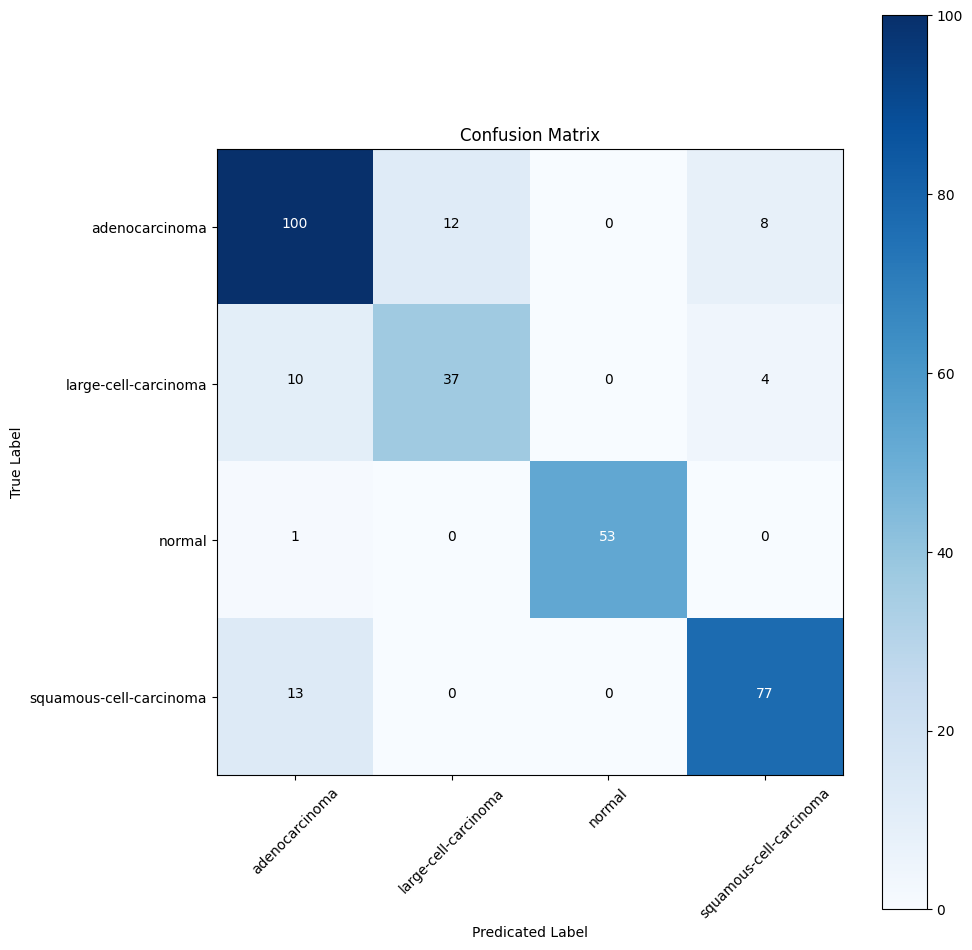

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['adenocarcinoma', 'large-cell-carcinoma', 'normal', 'squamous-cell-carcinoma']

cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm=cm, classes=target_names, title='Confusion Matrix')

print(classification_report(test_gen.classes, y_pred, target_names=target_names))
